### Install project

In [1]:
!git clone https://github.com/kornelro/cv_project.git

fatal: destination path 'cv_project' already exists and is not an empty directory.


In [2]:
!pip install cv_project/.

Processing ./cv_project
  Created wheel for src: filename=src-0.1.0-cp36-none-any.whl size=16310 sha256=f5dd1d90f8ae84c2eaf64bc114b9c4f14c3cd27c3a4932982e3b6971b753e06c
  Stored in directory: /tmp/pip-ephem-wheel-cache-z2ns3arq/wheels/fc/1b/40/72379bece2bafba26136079aeac87421c9221abafeb9c66746
Successfully built src
  Found existing installation: src 0.1.0
    Uninstalling src-0.1.0:
      Successfully uninstalled src-0.1.0


### Mount drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
DRIVE_PATH = '/content/drive/Shareddrives/CV-PROJECT/'

### Imports

In [5]:
pip install stellargraph

In [6]:
import pickle
import numpy as np
import tensorflow.keras as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from stellargraph.utils.history import plot_history

from src.data.make_dataset import make_dataset
from src.data.image_loaders import VehiculesFixedSizeImageLoader
from src.data.dataset_loaders import VehiculesDatasetLoader
from src.features.pipelines import RawImageToImage
from src.features.processors import NormImage, Blur
from src.models.classifiers import ResnetModelWrapper
from src.models.detectors import SliderProbDetector
from src.data.sliders import SlidingWindow
from src.evaluation import validate_model, precision, recall, f1_score

# Vehicules
# ResNet50
# Pipeline: Blur, Norm

### Load dataset

In [7]:
DATA_PATH = DRIVE_PATH+'data/processed/vehicules/resnet/data_resnet_blur.pickle'

In [8]:
with open(DATA_PATH, 'rb') as f:
    data = pickle.load(f)

### Train ResNet50

In [9]:
TEST_SIZE = 0.1
BATCH_SIZE = 100
EPOCHS = 5

In [10]:
X = np.array(list(map(lambda x: x[1], data)))
y = np.array(list(map(lambda x: x[2], data)))
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=42
  )


input_t = K.Input(shape=(X[0].shape))
res_model = K.applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_tensor=input_t
)

for layer in res_model.layers:
    layer.trainable = False

model = K.models.Sequential()
model.add(res_model)
model.add(K.layers.Flatten())
model.add(K.layers.Dense(2, activation='softmax'))


model.compile(
    optimizer=K.optimizers.Adam(0.001),
    loss=K.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(X_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS, 
            validation_data=(X_test, y_test)
)

Epoch 1/5
43/43 [==============================] - 14s 95ms/step - loss: 0.3108 - accuracy: 0.8834 - val_loss: 0.1659 - val_accuracy: 0.9597
Epoch 2/5
43/43 [==============================] - 2s 49ms/step - loss: 0.0326 - accuracy: 0.9898 - val_loss: 0.0853 - val_accuracy: 0.9831
Epoch 3/5
43/43 [==============================] - 2s 50ms/step - loss: 0.0068 - accuracy: 0.9981 - val_loss: 0.0818 - val_accuracy: 0.9809
Epoch 4/5
43/43 [==============================] - 2s 50ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0849 - val_accuracy: 0.9809
Epoch 5/5
43/43 [==============================] - 2s 50ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0753 - val_accuracy: 0.9852


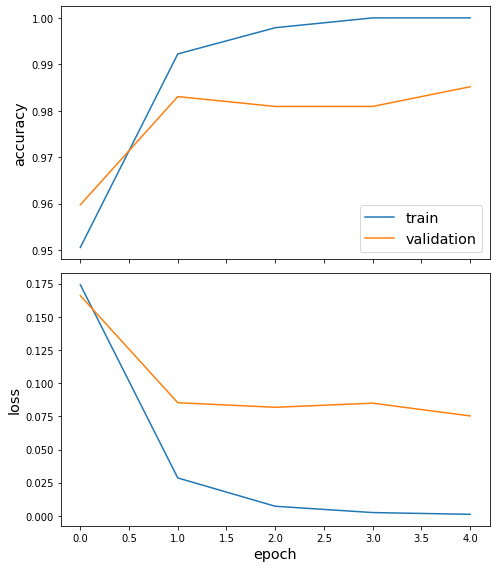

In [11]:
plot_history(history)

### Validation

In [12]:
del data

In [13]:
BND_BOX_SIZE = (50, 50)
STEP_SIZE = 20

dataset_loader = VehiculesDatasetLoader(
    image_loader=VehiculesFixedSizeImageLoader(
        bnd_box_size=BND_BOX_SIZE
    )
)

process_pipeline=RawImageToImage(
    processors=[
        Blur(),
        NormImage()
    ]
)

sliding_window = SlidingWindow(
    step_size=STEP_SIZE,
    window_size=BND_BOX_SIZE
)

treshold = 0.9; nms_overlap=0.4

In [14]:
slider_detector = SliderProbDetector(
    sliding_window=sliding_window,
    process_pipeline=process_pipeline,
    classifier=ResnetModelWrapper(model),
    treshold=0.9,
    nms_overlap=0.4
)

true_positives, false_positives, false_negatives, processed_images = validate_model(
    dataset_loader=dataset_loader,
    input_folder_filepath=DRIVE_PATH+'data/raw/vehicules/val',
    output_folder_filepath=DRIVE_PATH+'processed_images/resnet50/vehicules/blur/t9nms4',
    images_files_types=('png',),
    annotations_files_types=('txt',),
    detector=slider_detector,
    workers=0
)

print()
print('Precision:',  round(precision(true_positives, false_positives), 3))
print('Recall:',  round(recall(true_positives, false_negatives), 3))
print('F1Score:', round(f1_score(true_positives, false_positives, false_negatives), 3))

 11%|█         | 1/9 [00:06<00:53,  6.70s/it]

154


 22%|██▏       | 2/9 [00:11<00:43,  6.20s/it]

204


 33%|███▎      | 3/9 [00:16<00:35,  5.85s/it]

48


 44%|████▍     | 4/9 [00:21<00:28,  5.62s/it]

42


 56%|█████▌    | 5/9 [00:26<00:21,  5.48s/it]

184
177


 78%|███████▊  | 7/9 [01:00<00:20, 10.22s/it]

219


 89%|████████▉ | 8/9 [01:05<00:08,  8.74s/it]

162


100%|██████████| 9/9 [01:11<00:00,  7.90s/it]

133



Precision: 0.257
Recall: 0.876
F1Score: 0.398
